In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv("uber.csv")

In [3]:
# Step 1: Data Preprocessing
# Drop rows with missing values
data.dropna(inplace=True)

In [4]:
# Convert 'pickup_datetime' to datetime format and extract date features
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour
data['day'] = data['pickup_datetime'].dt.day
data['month'] = data['pickup_datetime'].dt.month
data['year'] = data['pickup_datetime'].dt.year

In [5]:
data.head(2)

,key,time,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year
0,24238194,52:06.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015
1,27835199,04:56.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009


In [6]:
# Calculate the distance between pickup and drop-off locations
def calculate_distance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    pickup_point = (pickup_latitude, pickup_longitude)  # (latitude, longitude)
    dropoff_point = (dropoff_latitude, dropoff_longitude)  # (latitude, longitude)
    return geodesic(pickup_point, dropoff_point).kilometers



# Check for invalid latitudes in the dataset
invalid_latitudes = data[(data['pickup_latitude'] < -90) | (data['pickup_latitude'] > 90) | 
                          (data['dropoff_latitude'] < -90) | (data['dropoff_latitude'] > 90)]
print(invalid_latitudes[['pickup_latitude', 'dropoff_latitude']])

# Specify the indices of rows to drop
indices_to_drop = [56617, 61793, 75851, 91422, 139447]

# Drop rows by index
df_cleaned = df.drop(index=indices_to_drop)


In [12]:
# Re-attempt the distance calculation
data['distance'] = data.apply(lambda row: calculate_distance(row['pickup_longitude'], row['pickup_latitude'], 
                                                            row['dropoff_longitude'], row['dropoff_latitude']), axis=1)


In [14]:
data.head(2)

,key,time,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance
0,24238194,52:06.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,1.681111
1,27835199,04:56.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,2.454363


In [15]:
# Drop unnecessary columns
data = data.drop(columns=['key', 'pickup_datetime'])

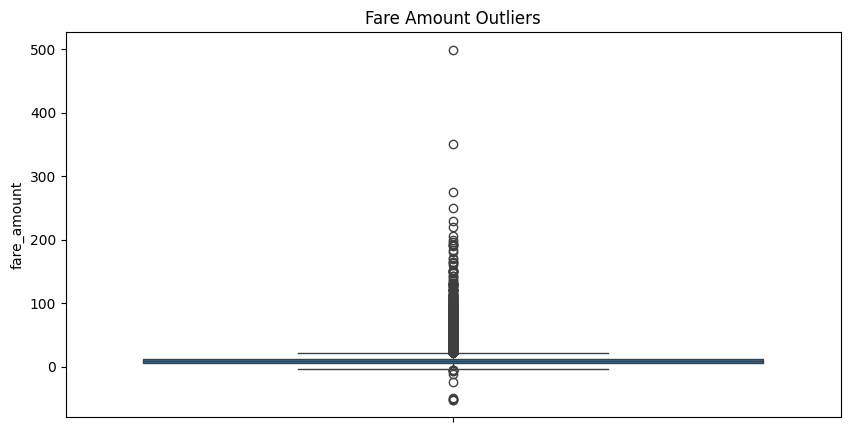

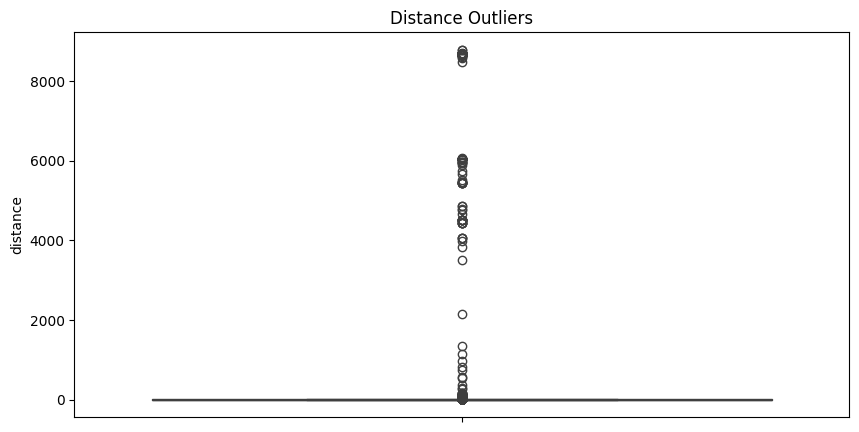

In [16]:
# Step 2: Identify Outliers
# Plot to identify outliers in fare_amount and distance
plt.figure(figsize=(10,5))
sns.boxplot(data['fare_amount'])
plt.title("Fare Amount Outliers")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data['distance'])
plt.title("Distance Outliers")
plt.show()

In [17]:
# Remove outliers: Filter fare_amount between 0 and 100, distance > 0, and passenger_count between 1 and 6
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 100)]
data = data[data['distance'] > 0]
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]


In [18]:
data.shape

(193575, 12)

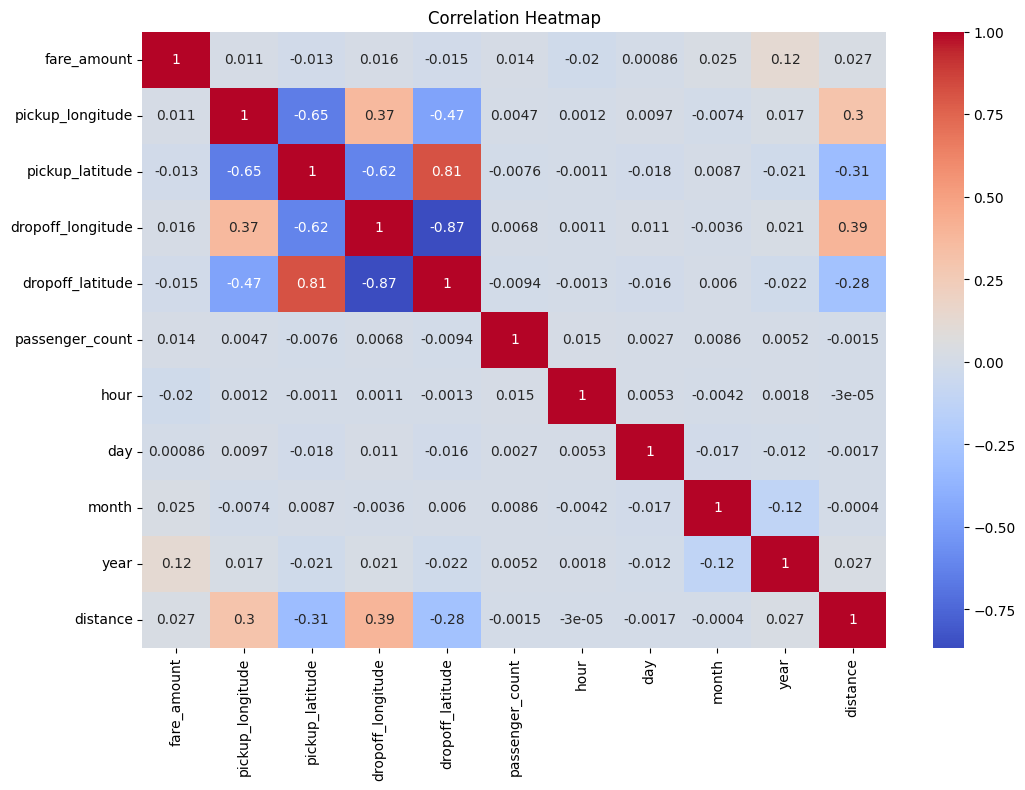

In [21]:
data = data.drop(columns = ['time'])
# Step 3: Check Correlation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [22]:
# Step 4: Model Implementation
# Define features and target variable
X = data[['distance', 'passenger_count', 'hour', 'day', 'month', 'year']]
y = data['fare_amount']

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)

In [25]:
# Random Forest Regression Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [26]:
# Step 5: Model Evaluation
# Linear Regression metrics
linear_r2 = r2_score(y_test, y_pred_linear)
linear_rmse = mean_squared_error(y_test, y_pred_linear, squared=False)
print("Linear Regression - R2:", linear_r2)
print("Linear Regression - RMSE:", linear_rmse)

Linear Regression - R2: 0.018908809254436165
Linear Regression - RMSE: 9.435174767936676


D:\programming\python\My Python Projects\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
# Random Forest Regression metrics
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print("Random Forest Regression - R2:", rf_r2)
print("Random Forest Regression - RMSE:", rf_rmse)

Random Forest Regression - R2: 0.8182970710445923
Random Forest Regression - RMSE: 4.060469240564468


D:\programming\python\My Python Projects\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
# Comparison
print("\nModel Comparison:")
print(f"Linear Regression: R2={linear_r2:.2f}, RMSE={linear_rmse:.2f}")
print(f"Random Forest: R2={rf_r2:.2f}, RMSE={rf_rmse:.2f}")


Model Comparison:
Linear Regression: R2=0.02, RMSE=9.44
Random Forest: R2=0.82, RMSE=4.06
